## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [17]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [18]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [19]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [20]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [21]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [22]:
import segmentation_models_pytorch as smp

In [23]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [24]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp023a'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 100 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 5e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [25]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [27]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [28]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [29]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


-------- exp_info -----------------


## image, mask

In [30]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [31]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [32]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [33]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [34]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [35]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [36]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [37]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

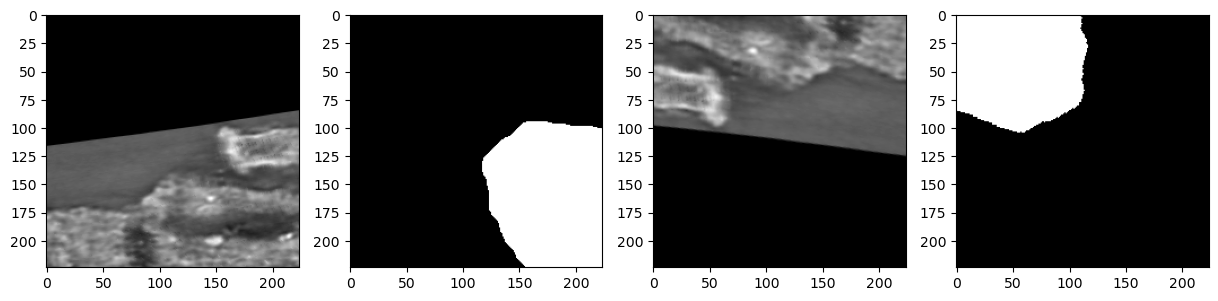

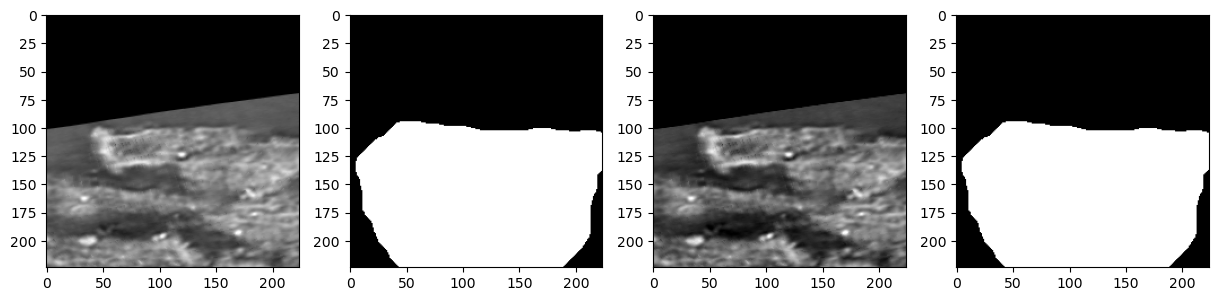

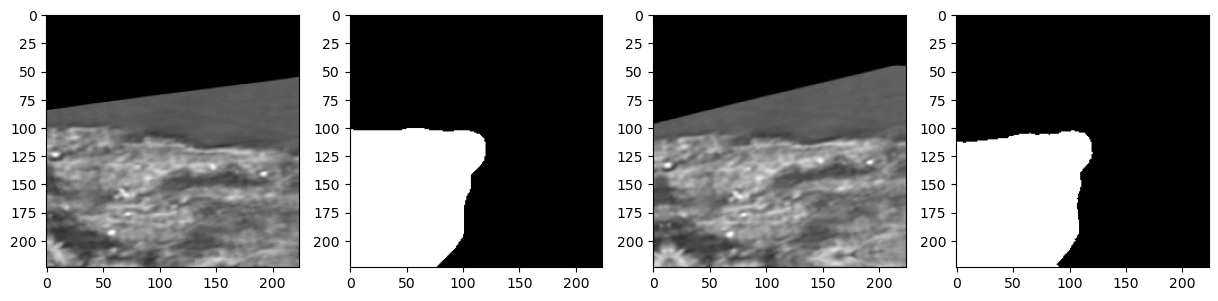

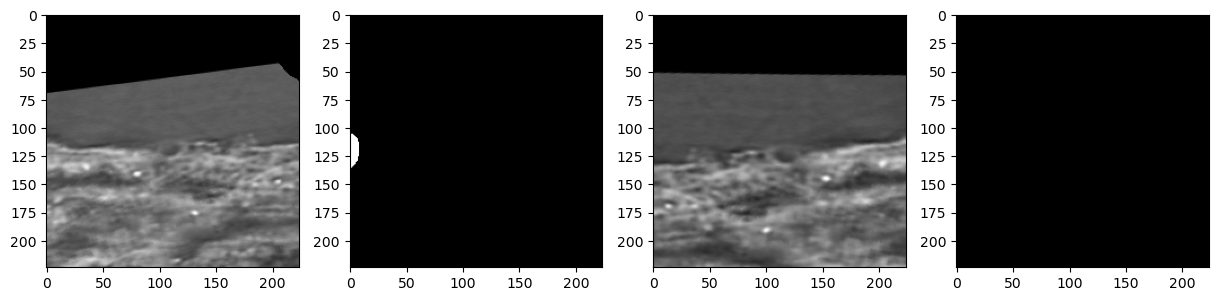

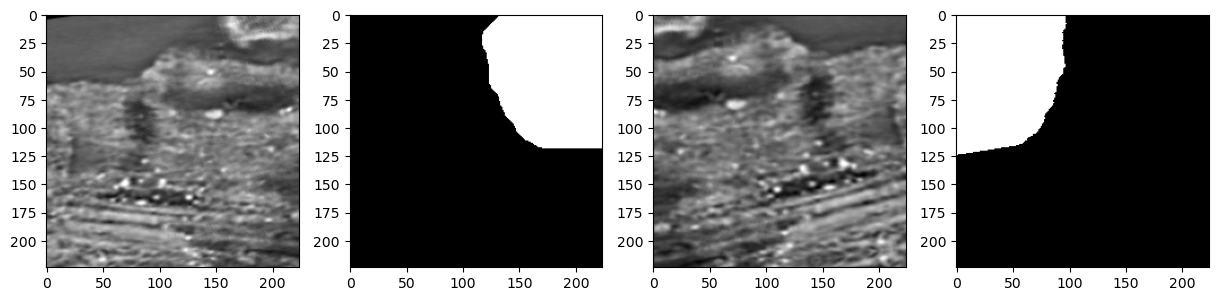

In [38]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [39]:
del plot_dataset
gc.collect()

48135

## model

In [40]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [41]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [42]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [43]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [44]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [45]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [46]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [47]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [48]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [49]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14177796309243887
th: 0.15, fbeta: 0.20166257822337835
th: 0.2, fbeta: 0.2736014462777374
th: 0.25, fbeta: 0.35646873028658926
th: 0.3, fbeta: 0.38321897506813063
th: 0.35, fbeta: 0.3768721636367229
th: 0.4, fbeta: 0.348165236090508
th: 0.45, fbeta: 0.30440671097089617


best_th: 0.3, fbeta: 0.38321897506813063
best_th: 0.3, fbeta: 0.38321897506813063
Epoch 1 - avg_train_loss: 0.4496  avg_val_loss: 0.3450  time: 125s
Epoch 1 - avg_train_loss: 0.4496  avg_val_loss: 0.3450  time: 125s
Epoch 1 - avgScore: 0.3832
Epoch 1 - avgScore: 0.3832
Epoch 1 - Save Best Score: 0.3832 Model
Epoch 1 - Save Best Score: 0.3832 Model
Epoch 1 - Save Best Loss: 0.3450 Model
Epoch 1 - Save Best Loss: 0.3450 Model


th: 0.5, fbeta: 0.25332670347180025


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2965342301568652
th: 0.15, fbeta: 0.3691975495861346
th: 0.2, fbeta: 0.36223129205888394
th: 0.25, fbeta: 0.303601179262535
th: 0.3, fbeta: 0.23848157376953985
th: 0.35, fbeta: 0.1789880437669112
th: 0.4, fbeta: 0.12533408679303065
th: 0.45, fbeta: 0.08312502750281908


best_th: 0.15, fbeta: 0.3691975495861346
best_th: 0.15, fbeta: 0.3691975495861346
Epoch 2 - avg_train_loss: 0.2614  avg_val_loss: 0.3265  time: 129s
Epoch 2 - avg_train_loss: 0.2614  avg_val_loss: 0.3265  time: 129s
Epoch 2 - avgScore: 0.3692
Epoch 2 - avgScore: 0.3692


th: 0.5, fbeta: 0.05273218642934113


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.31532416109682015
th: 0.15, fbeta: 0.3361513095215725
th: 0.2, fbeta: 0.28782880681721196
th: 0.25, fbeta: 0.2317821595390686
th: 0.3, fbeta: 0.18097081263825762
th: 0.35, fbeta: 0.13354392932664555
th: 0.4, fbeta: 0.09403449272520932
th: 0.45, fbeta: 0.0631976792837568


best_th: 0.15, fbeta: 0.3361513095215725
best_th: 0.15, fbeta: 0.3361513095215725
Epoch 3 - avg_train_loss: 0.2383  avg_val_loss: 0.3222  time: 130s
Epoch 3 - avg_train_loss: 0.2383  avg_val_loss: 0.3222  time: 130s
Epoch 3 - avgScore: 0.3362
Epoch 3 - avgScore: 0.3362


th: 0.5, fbeta: 0.029058189913513926


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.278804316033916
th: 0.15, fbeta: 0.1850630596874865
th: 0.2, fbeta: 0.11477291674326447
th: 0.25, fbeta: 0.0648899927790882
th: 0.3, fbeta: 0.03216890410512156
th: 0.35, fbeta: 0.014806517293855624
th: 0.4, fbeta: 0.00773011317908218
th: 0.45, fbeta: 0.0029545893328729654


best_th: 0.1, fbeta: 0.278804316033916
best_th: 0.1, fbeta: 0.278804316033916
Epoch 4 - avg_train_loss: 0.2156  avg_val_loss: 0.3783  time: 127s
Epoch 4 - avg_train_loss: 0.2156  avg_val_loss: 0.3783  time: 127s
Epoch 4 - avgScore: 0.2788
Epoch 4 - avgScore: 0.2788


th: 0.5, fbeta: 0.00048481422883879657


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3411959510449204
th: 0.15, fbeta: 0.24462281952096923
th: 0.2, fbeta: 0.1571679451283681
th: 0.25, fbeta: 0.102495253079258
th: 0.3, fbeta: 0.06785521926434365
th: 0.35, fbeta: 0.04676667754556941
th: 0.4, fbeta: 0.03132133004200951
th: 0.45, fbeta: 0.02032074575378112


best_th: 0.1, fbeta: 0.3411959510449204
best_th: 0.1, fbeta: 0.3411959510449204
Epoch 5 - avg_train_loss: 0.2058  avg_val_loss: 0.3629  time: 123s
Epoch 5 - avg_train_loss: 0.2058  avg_val_loss: 0.3629  time: 123s
Epoch 5 - avgScore: 0.3412
Epoch 5 - avgScore: 0.3412


th: 0.5, fbeta: 0.013743131018113138


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3554270107007786
th: 0.15, fbeta: 0.3217524944824184
th: 0.2, fbeta: 0.2745469222161362
th: 0.25, fbeta: 0.21564711069126413
th: 0.3, fbeta: 0.16627247040339257
th: 0.35, fbeta: 0.12933146356069888
th: 0.4, fbeta: 0.10107223375919996
th: 0.45, fbeta: 0.07982619081348145


best_th: 0.1, fbeta: 0.3554270107007786
best_th: 0.1, fbeta: 0.3554270107007786
Epoch 6 - avg_train_loss: 0.2006  avg_val_loss: 0.4378  time: 121s
Epoch 6 - avg_train_loss: 0.2006  avg_val_loss: 0.4378  time: 121s
Epoch 6 - avgScore: 0.3554
Epoch 6 - avgScore: 0.3554


th: 0.5, fbeta: 0.05930991513426495


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36414989956493177
th: 0.15, fbeta: 0.3822996654410517
th: 0.2, fbeta: 0.3831137134335384
th: 0.25, fbeta: 0.3753378664020949
th: 0.3, fbeta: 0.35909134935485754
th: 0.35, fbeta: 0.3359649654076018
th: 0.4, fbeta: 0.31333144523974465
th: 0.45, fbeta: 0.28799865120721696


best_th: 0.2, fbeta: 0.3831137134335384
best_th: 0.2, fbeta: 0.3831137134335384
Epoch 7 - avg_train_loss: 0.1963  avg_val_loss: 0.3698  time: 130s
Epoch 7 - avg_train_loss: 0.1963  avg_val_loss: 0.3698  time: 130s
Epoch 7 - avgScore: 0.3831
Epoch 7 - avgScore: 0.3831


th: 0.5, fbeta: 0.26190483874028764


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3720196064399325
th: 0.15, fbeta: 0.3847139524028891
th: 0.2, fbeta: 0.3842030853517522
th: 0.25, fbeta: 0.3751671682713071
th: 0.3, fbeta: 0.3559818116203608
th: 0.35, fbeta: 0.32999489784692704
th: 0.4, fbeta: 0.3007279415916782
th: 0.45, fbeta: 0.27270940684776335


best_th: 0.15, fbeta: 0.3847139524028891
best_th: 0.15, fbeta: 0.3847139524028891
Epoch 8 - avg_train_loss: 0.1920  avg_val_loss: 0.4060  time: 129s
Epoch 8 - avg_train_loss: 0.1920  avg_val_loss: 0.4060  time: 129s
Epoch 8 - avgScore: 0.3847
Epoch 8 - avgScore: 0.3847
Epoch 8 - Save Best Score: 0.3847 Model
Epoch 8 - Save Best Score: 0.3847 Model
Epoch 8 - Save Best Loss: 0.4060 Model
Epoch 8 - Save Best Loss: 0.4060 Model


th: 0.5, fbeta: 0.24376379953598526


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3363660183892151
th: 0.15, fbeta: 0.37494414502656714
th: 0.2, fbeta: 0.393020980441286
th: 0.25, fbeta: 0.3991978401005287
th: 0.3, fbeta: 0.4012188417059483
th: 0.35, fbeta: 0.39134222777494465
th: 0.4, fbeta: 0.3731329053879788
th: 0.45, fbeta: 0.3469634228480872


best_th: 0.3, fbeta: 0.4012188417059483
best_th: 0.3, fbeta: 0.4012188417059483
Epoch 9 - avg_train_loss: 0.1897  avg_val_loss: 0.3147  time: 130s
Epoch 9 - avg_train_loss: 0.1897  avg_val_loss: 0.3147  time: 130s
Epoch 9 - avgScore: 0.4012
Epoch 9 - avgScore: 0.4012
Epoch 9 - Save Best Score: 0.4012 Model
Epoch 9 - Save Best Score: 0.4012 Model
Epoch 9 - Save Best Loss: 0.3147 Model
Epoch 9 - Save Best Loss: 0.3147 Model


th: 0.5, fbeta: 0.31165524655312477


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3621123280298442
th: 0.15, fbeta: 0.3133852692647337
th: 0.2, fbeta: 0.25925088773082666
th: 0.25, fbeta: 0.21556266085359138
th: 0.3, fbeta: 0.18094258634455204
th: 0.35, fbeta: 0.14988598485548968
th: 0.4, fbeta: 0.12166759845567274
th: 0.45, fbeta: 0.0971941406599216


best_th: 0.1, fbeta: 0.3621123280298442
best_th: 0.1, fbeta: 0.3621123280298442
Epoch 10 - avg_train_loss: 0.1880  avg_val_loss: 0.4075  time: 129s
Epoch 10 - avg_train_loss: 0.1880  avg_val_loss: 0.4075  time: 129s
Epoch 10 - avgScore: 0.3621
Epoch 10 - avgScore: 0.3621


th: 0.5, fbeta: 0.07413070426156404


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3975259775374442
th: 0.15, fbeta: 0.39772696616117176
th: 0.2, fbeta: 0.3728008377744909
th: 0.25, fbeta: 0.3314456389741816
th: 0.3, fbeta: 0.28336023223490153
th: 0.35, fbeta: 0.22891816199222817
th: 0.4, fbeta: 0.1750685505000527
th: 0.45, fbeta: 0.1286387797175416


best_th: 0.15, fbeta: 0.39772696616117176
best_th: 0.15, fbeta: 0.39772696616117176
Epoch 11 - avg_train_loss: 0.1829  avg_val_loss: 0.4080  time: 127s
Epoch 11 - avg_train_loss: 0.1829  avg_val_loss: 0.4080  time: 127s
Epoch 11 - avgScore: 0.3977
Epoch 11 - avgScore: 0.3977


th: 0.5, fbeta: 0.09606772082588821


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4094382157756279
th: 0.15, fbeta: 0.41161359874712455
th: 0.2, fbeta: 0.39641244981270424
th: 0.25, fbeta: 0.36939122453912576
th: 0.3, fbeta: 0.3343364635197307
th: 0.35, fbeta: 0.2925702559939258
th: 0.4, fbeta: 0.24334381071496927
th: 0.45, fbeta: 0.19724973435146284


best_th: 0.15, fbeta: 0.41161359874712455
best_th: 0.15, fbeta: 0.41161359874712455
Epoch 12 - avg_train_loss: 0.1791  avg_val_loss: 0.4629  time: 128s
Epoch 12 - avg_train_loss: 0.1791  avg_val_loss: 0.4629  time: 128s
Epoch 12 - avgScore: 0.4116
Epoch 12 - avgScore: 0.4116
Epoch 12 - Save Best Score: 0.4116 Model
Epoch 12 - Save Best Score: 0.4116 Model
Epoch 12 - Save Best Loss: 0.4629 Model
Epoch 12 - Save Best Loss: 0.4629 Model


th: 0.5, fbeta: 0.1564205653095605


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30545203020550443
th: 0.15, fbeta: 0.33788193330248545
th: 0.2, fbeta: 0.36805648402378943
th: 0.25, fbeta: 0.393641936654814
th: 0.3, fbeta: 0.4125475249511291
th: 0.35, fbeta: 0.4238459874184984
th: 0.4, fbeta: 0.4249622321458881
th: 0.45, fbeta: 0.41993211238341543


best_th: 0.4, fbeta: 0.4249622321458881
best_th: 0.4, fbeta: 0.4249622321458881
Epoch 13 - avg_train_loss: 0.1758  avg_val_loss: 0.3414  time: 129s
Epoch 13 - avg_train_loss: 0.1758  avg_val_loss: 0.3414  time: 129s
Epoch 13 - avgScore: 0.4250
Epoch 13 - avgScore: 0.4250
Epoch 13 - Save Best Score: 0.4250 Model
Epoch 13 - Save Best Score: 0.4250 Model
Epoch 13 - Save Best Loss: 0.3414 Model
Epoch 13 - Save Best Loss: 0.3414 Model


th: 0.5, fbeta: 0.4079341339648163


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3863812762225252
th: 0.15, fbeta: 0.38575853022911505
th: 0.2, fbeta: 0.3643063444701692
th: 0.25, fbeta: 0.31870465759862493
th: 0.3, fbeta: 0.2595072358743695
th: 0.35, fbeta: 0.2011477429506322
th: 0.4, fbeta: 0.1515960045833309
th: 0.45, fbeta: 0.11311593200560001


best_th: 0.1, fbeta: 0.3863812762225252
best_th: 0.1, fbeta: 0.3863812762225252
Epoch 14 - avg_train_loss: 0.1756  avg_val_loss: 0.3857  time: 131s
Epoch 14 - avg_train_loss: 0.1756  avg_val_loss: 0.3857  time: 131s
Epoch 14 - avgScore: 0.3864
Epoch 14 - avgScore: 0.3864


th: 0.5, fbeta: 0.0783481781912905


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38631123650056703
th: 0.15, fbeta: 0.4130683551804177
th: 0.2, fbeta: 0.4232437572041403
th: 0.25, fbeta: 0.41815822283835025
th: 0.3, fbeta: 0.40658357303971876
th: 0.35, fbeta: 0.3878092459551174
th: 0.4, fbeta: 0.3613886036273271
th: 0.45, fbeta: 0.3288121496344308


best_th: 0.2, fbeta: 0.4232437572041403
best_th: 0.2, fbeta: 0.4232437572041403
Epoch 15 - avg_train_loss: 0.1740  avg_val_loss: 0.4138  time: 129s
Epoch 15 - avg_train_loss: 0.1740  avg_val_loss: 0.4138  time: 129s
Epoch 15 - avgScore: 0.4232
Epoch 15 - avgScore: 0.4232


th: 0.5, fbeta: 0.29489137159948553


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32459413358112044
th: 0.15, fbeta: 0.3572938083730148
th: 0.2, fbeta: 0.3793807982593373
th: 0.25, fbeta: 0.3931063267327274
th: 0.3, fbeta: 0.3992471724467136
th: 0.35, fbeta: 0.3991007310184383
th: 0.4, fbeta: 0.3925524487686288
th: 0.45, fbeta: 0.3780127436320747


best_th: 0.3, fbeta: 0.3992471724467136
best_th: 0.3, fbeta: 0.3992471724467136
Epoch 16 - avg_train_loss: 0.1689  avg_val_loss: 0.3811  time: 129s
Epoch 16 - avg_train_loss: 0.1689  avg_val_loss: 0.3811  time: 129s
Epoch 16 - avgScore: 0.3992
Epoch 16 - avgScore: 0.3992


th: 0.5, fbeta: 0.35565990382595747


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35558137153887087
th: 0.15, fbeta: 0.3834533195955832
th: 0.2, fbeta: 0.38879649585348036
th: 0.25, fbeta: 0.38315835135226173
th: 0.3, fbeta: 0.37340835578268256
th: 0.35, fbeta: 0.35846989381194533
th: 0.4, fbeta: 0.337427517781415
th: 0.45, fbeta: 0.3117782686453492


best_th: 0.2, fbeta: 0.38879649585348036
best_th: 0.2, fbeta: 0.38879649585348036
Epoch 17 - avg_train_loss: 0.1657  avg_val_loss: 0.3747  time: 129s
Epoch 17 - avg_train_loss: 0.1657  avg_val_loss: 0.3747  time: 129s
Epoch 17 - avgScore: 0.3888
Epoch 17 - avgScore: 0.3888


th: 0.5, fbeta: 0.28229838014449304


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3959615729677473
th: 0.15, fbeta: 0.40673879035319
th: 0.2, fbeta: 0.40718321094294696
th: 0.25, fbeta: 0.400958625622008
th: 0.3, fbeta: 0.3894655051927703
th: 0.35, fbeta: 0.3753849160201497
th: 0.4, fbeta: 0.35519686980388254
th: 0.45, fbeta: 0.32870912822166254


best_th: 0.2, fbeta: 0.40718321094294696
best_th: 0.2, fbeta: 0.40718321094294696
Epoch 18 - avg_train_loss: 0.1632  avg_val_loss: 0.4112  time: 128s
Epoch 18 - avg_train_loss: 0.1632  avg_val_loss: 0.4112  time: 128s
Epoch 18 - avgScore: 0.4072
Epoch 18 - avgScore: 0.4072


th: 0.5, fbeta: 0.30194997752196107


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37527149904225293
th: 0.15, fbeta: 0.3170457235174248
th: 0.2, fbeta: 0.2554902794591849
th: 0.25, fbeta: 0.19492631821450476
th: 0.3, fbeta: 0.14654105308869061
th: 0.35, fbeta: 0.11268821436103109
th: 0.4, fbeta: 0.0860330397728127
th: 0.45, fbeta: 0.06481242443197932


best_th: 0.1, fbeta: 0.37527149904225293
best_th: 0.1, fbeta: 0.37527149904225293
Epoch 19 - avg_train_loss: 0.1583  avg_val_loss: 0.5044  time: 127s
Epoch 19 - avg_train_loss: 0.1583  avg_val_loss: 0.5044  time: 127s
Epoch 19 - avgScore: 0.3753
Epoch 19 - avgScore: 0.3753


th: 0.5, fbeta: 0.04812557193336643


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33516911852715353
th: 0.15, fbeta: 0.28626844202039375
th: 0.2, fbeta: 0.24521262347862913
th: 0.25, fbeta: 0.20579382495963158
th: 0.3, fbeta: 0.166127572291192
th: 0.35, fbeta: 0.13222790615451746
th: 0.4, fbeta: 0.09911273873912306
th: 0.45, fbeta: 0.07357050864291681


best_th: 0.1, fbeta: 0.33516911852715353
best_th: 0.1, fbeta: 0.33516911852715353
Epoch 20 - avg_train_loss: 0.1587  avg_val_loss: 0.5251  time: 128s
Epoch 20 - avg_train_loss: 0.1587  avg_val_loss: 0.5251  time: 128s
Epoch 20 - avgScore: 0.3352
Epoch 20 - avgScore: 0.3352


th: 0.5, fbeta: 0.05328273863015313


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36980616905961267
th: 0.15, fbeta: 0.34139952560068226
th: 0.2, fbeta: 0.31130184288807683
th: 0.25, fbeta: 0.27832123132996356
th: 0.3, fbeta: 0.24710770457449743
th: 0.35, fbeta: 0.21572896029493768
th: 0.4, fbeta: 0.18546401095765006
th: 0.45, fbeta: 0.15380391884387964


best_th: 0.1, fbeta: 0.36980616905961267
best_th: 0.1, fbeta: 0.36980616905961267
Epoch 21 - avg_train_loss: 0.1551  avg_val_loss: 0.4967  time: 128s
Epoch 21 - avg_train_loss: 0.1551  avg_val_loss: 0.4967  time: 128s
Epoch 21 - avgScore: 0.3698
Epoch 21 - avgScore: 0.3698


th: 0.5, fbeta: 0.1287221086202464


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4077419675781535
th: 0.15, fbeta: 0.42142897725375467
th: 0.2, fbeta: 0.41936933319505304
th: 0.25, fbeta: 0.40968344973571436
th: 0.3, fbeta: 0.39636500553356374
th: 0.35, fbeta: 0.3783080922829065
th: 0.4, fbeta: 0.35948464766905397
th: 0.45, fbeta: 0.3392356252241852


best_th: 0.15, fbeta: 0.42142897725375467
best_th: 0.15, fbeta: 0.42142897725375467
Epoch 22 - avg_train_loss: 0.1500  avg_val_loss: 0.4795  time: 126s
Epoch 22 - avg_train_loss: 0.1500  avg_val_loss: 0.4795  time: 126s
Epoch 22 - avgScore: 0.4214
Epoch 22 - avgScore: 0.4214


th: 0.5, fbeta: 0.31687617130268825


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36884640728825896
th: 0.15, fbeta: 0.38749209984332283
th: 0.2, fbeta: 0.39920228284518255
th: 0.25, fbeta: 0.4042048757961363
th: 0.3, fbeta: 0.40349969017604975
th: 0.35, fbeta: 0.3984018348790288
th: 0.4, fbeta: 0.39147090548853786
th: 0.45, fbeta: 0.3827857163280711


best_th: 0.25, fbeta: 0.4042048757961363
best_th: 0.25, fbeta: 0.4042048757961363
Epoch 23 - avg_train_loss: 0.1499  avg_val_loss: 0.4420  time: 128s
Epoch 23 - avg_train_loss: 0.1499  avg_val_loss: 0.4420  time: 128s
Epoch 23 - avgScore: 0.4042
Epoch 23 - avgScore: 0.4042


th: 0.5, fbeta: 0.3683539949887069


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.392419806617942
th: 0.15, fbeta: 0.4186810746782222
th: 0.2, fbeta: 0.4187718291512651
th: 0.25, fbeta: 0.408977921652998
th: 0.3, fbeta: 0.3905034844741877
th: 0.35, fbeta: 0.3613766815760466
th: 0.4, fbeta: 0.32693700798553155
th: 0.45, fbeta: 0.2931792708515995


best_th: 0.2, fbeta: 0.4187718291512651
best_th: 0.2, fbeta: 0.4187718291512651
Epoch 24 - avg_train_loss: 0.1444  avg_val_loss: 0.4202  time: 128s
Epoch 24 - avg_train_loss: 0.1444  avg_val_loss: 0.4202  time: 128s
Epoch 24 - avgScore: 0.4188
Epoch 24 - avgScore: 0.4188


th: 0.5, fbeta: 0.26061489110919694


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3688047578212669
th: 0.15, fbeta: 0.388412346392457
th: 0.2, fbeta: 0.3982996505418389
th: 0.25, fbeta: 0.4007394392857528
th: 0.3, fbeta: 0.3955135651592326
th: 0.35, fbeta: 0.38485864021449795
th: 0.4, fbeta: 0.37197503071178106
th: 0.45, fbeta: 0.35769167657312523


best_th: 0.25, fbeta: 0.4007394392857528
best_th: 0.25, fbeta: 0.4007394392857528
Epoch 25 - avg_train_loss: 0.1437  avg_val_loss: 0.4608  time: 128s
Epoch 25 - avg_train_loss: 0.1437  avg_val_loss: 0.4608  time: 128s
Epoch 25 - avgScore: 0.4007
Epoch 25 - avgScore: 0.4007


th: 0.5, fbeta: 0.33796136140943517


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4104131365409518
th: 0.15, fbeta: 0.38329089524087356
th: 0.2, fbeta: 0.3399435938778543
th: 0.25, fbeta: 0.29304818033732666
th: 0.3, fbeta: 0.24672542218685378
th: 0.35, fbeta: 0.21078242533513628
th: 0.4, fbeta: 0.17946856677807388
th: 0.45, fbeta: 0.14891987247829155


best_th: 0.1, fbeta: 0.4104131365409518
best_th: 0.1, fbeta: 0.4104131365409518
Epoch 26 - avg_train_loss: 0.1430  avg_val_loss: 0.4892  time: 129s
Epoch 26 - avg_train_loss: 0.1430  avg_val_loss: 0.4892  time: 129s
Epoch 26 - avgScore: 0.4104
Epoch 26 - avgScore: 0.4104


th: 0.5, fbeta: 0.12086880763241335


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40717216045860133
th: 0.15, fbeta: 0.4055919325227607
th: 0.2, fbeta: 0.3915695380063824
th: 0.25, fbeta: 0.37361297785390146
th: 0.3, fbeta: 0.3565826298757955
th: 0.35, fbeta: 0.3374621035580864
th: 0.4, fbeta: 0.3189505039734675
th: 0.45, fbeta: 0.2993494562345195


best_th: 0.1, fbeta: 0.40717216045860133
best_th: 0.1, fbeta: 0.40717216045860133
Epoch 27 - avg_train_loss: 0.1376  avg_val_loss: 0.5063  time: 127s
Epoch 27 - avg_train_loss: 0.1376  avg_val_loss: 0.5063  time: 127s
Epoch 27 - avgScore: 0.4072
Epoch 27 - avgScore: 0.4072


th: 0.5, fbeta: 0.27775374480028114


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.399251730766679
th: 0.15, fbeta: 0.3983394500011999
th: 0.2, fbeta: 0.38928581226634207
th: 0.25, fbeta: 0.374697304321637
th: 0.3, fbeta: 0.3593545453721379
th: 0.35, fbeta: 0.3389175489578563
th: 0.4, fbeta: 0.3133475812978662
th: 0.45, fbeta: 0.2875294598763427


best_th: 0.1, fbeta: 0.399251730766679
best_th: 0.1, fbeta: 0.399251730766679
Epoch 28 - avg_train_loss: 0.1333  avg_val_loss: 0.5740  time: 125s
Epoch 28 - avg_train_loss: 0.1333  avg_val_loss: 0.5740  time: 125s
Epoch 28 - avgScore: 0.3993
Epoch 28 - avgScore: 0.3993


th: 0.5, fbeta: 0.25945849722062364


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.40365812100360554
th: 0.15, fbeta: 0.38308526244944835
th: 0.2, fbeta: 0.3517630121461833
th: 0.25, fbeta: 0.3189893906052954
th: 0.3, fbeta: 0.2874640430421611
th: 0.35, fbeta: 0.25104827444494127
th: 0.4, fbeta: 0.21383685536047403
th: 0.45, fbeta: 0.1783400621617509


best_th: 0.1, fbeta: 0.40365812100360554
best_th: 0.1, fbeta: 0.40365812100360554
Epoch 29 - avg_train_loss: 0.1296  avg_val_loss: 0.5300  time: 129s
Epoch 29 - avg_train_loss: 0.1296  avg_val_loss: 0.5300  time: 129s
Epoch 29 - avgScore: 0.4037
Epoch 29 - avgScore: 0.4037


th: 0.5, fbeta: 0.1456409830552785


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2812742402511681
th: 0.15, fbeta: 0.24592633563394653
th: 0.2, fbeta: 0.21088598538348724
th: 0.25, fbeta: 0.1819614547849693
th: 0.3, fbeta: 0.15613579053206034
th: 0.35, fbeta: 0.13015958625781132
th: 0.4, fbeta: 0.10780544625976768
th: 0.45, fbeta: 0.0898692568165469


best_th: 0.1, fbeta: 0.2812742402511681
best_th: 0.1, fbeta: 0.2812742402511681
Epoch 30 - avg_train_loss: 0.1296  avg_val_loss: 0.6874  time: 117s
Epoch 30 - avg_train_loss: 0.1296  avg_val_loss: 0.6874  time: 117s
Epoch 30 - avgScore: 0.2813
Epoch 30 - avgScore: 0.2813


th: 0.5, fbeta: 0.07569147129313354


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4227782997675849
th: 0.15, fbeta: 0.4240912174612534
th: 0.2, fbeta: 0.41688987169457314
th: 0.25, fbeta: 0.40150933877910605
th: 0.3, fbeta: 0.3825955245290425
th: 0.35, fbeta: 0.3574564394585762
th: 0.4, fbeta: 0.3304128228953292
th: 0.45, fbeta: 0.30132032719551294


best_th: 0.15, fbeta: 0.4240912174612534
best_th: 0.15, fbeta: 0.4240912174612534
Epoch 31 - avg_train_loss: 0.1254  avg_val_loss: 0.5212  time: 118s
Epoch 31 - avg_train_loss: 0.1254  avg_val_loss: 0.5212  time: 118s
Epoch 31 - avgScore: 0.4241
Epoch 31 - avgScore: 0.4241


th: 0.5, fbeta: 0.27192208994650663


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4105258193602241
th: 0.15, fbeta: 0.39467708079860697
th: 0.2, fbeta: 0.36745134069887886
th: 0.25, fbeta: 0.3422249607349503
th: 0.3, fbeta: 0.31499074603565747
th: 0.35, fbeta: 0.2883250163450831
th: 0.4, fbeta: 0.26188683981232924
th: 0.45, fbeta: 0.23165499216717475


best_th: 0.1, fbeta: 0.4105258193602241
best_th: 0.1, fbeta: 0.4105258193602241
Epoch 32 - avg_train_loss: 0.1287  avg_val_loss: 0.5647  time: 117s
Epoch 32 - avg_train_loss: 0.1287  avg_val_loss: 0.5647  time: 117s
Epoch 32 - avgScore: 0.4105
Epoch 32 - avgScore: 0.4105


th: 0.5, fbeta: 0.20142476826039102


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3795986306390418
th: 0.15, fbeta: 0.3656555407596157
th: 0.2, fbeta: 0.3406605539373721
th: 0.25, fbeta: 0.31179268730111304
th: 0.3, fbeta: 0.28121350433814807
th: 0.35, fbeta: 0.2509044998570673
th: 0.4, fbeta: 0.22100184151350868
th: 0.45, fbeta: 0.193589110016758


best_th: 0.1, fbeta: 0.3795986306390418
best_th: 0.1, fbeta: 0.3795986306390418
Epoch 33 - avg_train_loss: 0.1235  avg_val_loss: 0.5730  time: 124s
Epoch 33 - avg_train_loss: 0.1235  avg_val_loss: 0.5730  time: 124s
Epoch 33 - avgScore: 0.3796
Epoch 33 - avgScore: 0.3796


th: 0.5, fbeta: 0.1663288460157678


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37947319042341376
th: 0.15, fbeta: 0.3584380085992801
th: 0.2, fbeta: 0.3332310482655338
th: 0.25, fbeta: 0.30398541904334286
th: 0.3, fbeta: 0.27201868007509644
th: 0.35, fbeta: 0.24136725909734028
th: 0.4, fbeta: 0.21249133644350726
th: 0.45, fbeta: 0.18718746315960116


best_th: 0.1, fbeta: 0.37947319042341376
best_th: 0.1, fbeta: 0.37947319042341376
Epoch 34 - avg_train_loss: 0.1191  avg_val_loss: 0.6832  time: 123s
Epoch 34 - avg_train_loss: 0.1191  avg_val_loss: 0.6832  time: 123s
Epoch 34 - avgScore: 0.3795
Epoch 34 - avgScore: 0.3795


th: 0.5, fbeta: 0.16591829827573287


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3019631606327045
th: 0.15, fbeta: 0.26060570185428494
th: 0.2, fbeta: 0.22542280776674684
th: 0.25, fbeta: 0.1936375571541646
th: 0.3, fbeta: 0.1628829889708666
th: 0.35, fbeta: 0.13483991683789012
th: 0.4, fbeta: 0.11048509429773097
th: 0.45, fbeta: 0.08890255412437324


best_th: 0.1, fbeta: 0.3019631606327045
best_th: 0.1, fbeta: 0.3019631606327045
Epoch 35 - avg_train_loss: 0.1172  avg_val_loss: 0.6517  time: 123s
Epoch 35 - avg_train_loss: 0.1172  avg_val_loss: 0.6517  time: 123s
Epoch 35 - avgScore: 0.3020
Epoch 35 - avgScore: 0.3020


th: 0.5, fbeta: 0.07179157458857914


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4172928468764007
th: 0.15, fbeta: 0.42161376584284327
th: 0.2, fbeta: 0.41304070442440655
th: 0.25, fbeta: 0.40057125278412264
th: 0.3, fbeta: 0.3845717684579736
th: 0.35, fbeta: 0.3672291653621298
th: 0.4, fbeta: 0.3466845756771263
th: 0.45, fbeta: 0.322840719467086


best_th: 0.15, fbeta: 0.42161376584284327
best_th: 0.15, fbeta: 0.42161376584284327
Epoch 36 - avg_train_loss: 0.1189  avg_val_loss: 0.5267  time: 121s
Epoch 36 - avg_train_loss: 0.1189  avg_val_loss: 0.5267  time: 121s
Epoch 36 - avgScore: 0.4216
Epoch 36 - avgScore: 0.4216


th: 0.5, fbeta: 0.2957956213574996


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39917010480878273
th: 0.15, fbeta: 0.3969231968483294
th: 0.2, fbeta: 0.38561251103323696
th: 0.25, fbeta: 0.3699177939999332
th: 0.3, fbeta: 0.348790737468867
th: 0.35, fbeta: 0.32395014594311594
th: 0.4, fbeta: 0.29673160444461194
th: 0.45, fbeta: 0.26598692915329303


best_th: 0.1, fbeta: 0.39917010480878273
best_th: 0.1, fbeta: 0.39917010480878273
Epoch 37 - avg_train_loss: 0.1147  avg_val_loss: 0.5968  time: 121s
Epoch 37 - avg_train_loss: 0.1147  avg_val_loss: 0.5968  time: 121s
Epoch 37 - avgScore: 0.3992
Epoch 37 - avgScore: 0.3992


th: 0.5, fbeta: 0.23512144984625635


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39646773203100855
th: 0.15, fbeta: 0.40294332117004517
th: 0.2, fbeta: 0.400174546790149
th: 0.25, fbeta: 0.39082147427897607
th: 0.3, fbeta: 0.378070005970173
th: 0.35, fbeta: 0.360243888294482
th: 0.4, fbeta: 0.3368067584587684
th: 0.45, fbeta: 0.3104724483882012


best_th: 0.15, fbeta: 0.40294332117004517
best_th: 0.15, fbeta: 0.40294332117004517
Epoch 38 - avg_train_loss: 0.1148  avg_val_loss: 0.5709  time: 121s
Epoch 38 - avg_train_loss: 0.1148  avg_val_loss: 0.5709  time: 121s
Epoch 38 - avgScore: 0.4029
Epoch 38 - avgScore: 0.4029


th: 0.5, fbeta: 0.28407106614607963


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3705720681661486
th: 0.15, fbeta: 0.36060773834786525
th: 0.2, fbeta: 0.34229395299600657
th: 0.25, fbeta: 0.31787817388492146
th: 0.3, fbeta: 0.29352765025554295
th: 0.35, fbeta: 0.2674328400863295
th: 0.4, fbeta: 0.23983782625640052
th: 0.45, fbeta: 0.20839271751089838


best_th: 0.1, fbeta: 0.3705720681661486
best_th: 0.1, fbeta: 0.3705720681661486
Epoch 39 - avg_train_loss: 0.1064  avg_val_loss: 0.6339  time: 123s
Epoch 39 - avg_train_loss: 0.1064  avg_val_loss: 0.6339  time: 123s
Epoch 39 - avgScore: 0.3706
Epoch 39 - avgScore: 0.3706


th: 0.5, fbeta: 0.1812568958928588


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3970373587830921
th: 0.15, fbeta: 0.40217516766459677
th: 0.2, fbeta: 0.39827547280499576
th: 0.25, fbeta: 0.3912967770837759
th: 0.3, fbeta: 0.3796387150869817
th: 0.35, fbeta: 0.36423384775432344
th: 0.4, fbeta: 0.3451091898271744
th: 0.45, fbeta: 0.32233762676666206


best_th: 0.15, fbeta: 0.40217516766459677
best_th: 0.15, fbeta: 0.40217516766459677
Epoch 40 - avg_train_loss: 0.1101  avg_val_loss: 0.5507  time: 126s
Epoch 40 - avg_train_loss: 0.1101  avg_val_loss: 0.5507  time: 126s
Epoch 40 - avgScore: 0.4022
Epoch 40 - avgScore: 0.4022


th: 0.5, fbeta: 0.29922802419074546


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4046590534048488
th: 0.15, fbeta: 0.3796398876316718
th: 0.2, fbeta: 0.34335032678178157
th: 0.25, fbeta: 0.31184815395860616
th: 0.3, fbeta: 0.28120813773902076
th: 0.35, fbeta: 0.2515435867955741
th: 0.4, fbeta: 0.22264878892738113
th: 0.45, fbeta: 0.19594554433869943


best_th: 0.1, fbeta: 0.4046590534048488
best_th: 0.1, fbeta: 0.4046590534048488
Epoch 41 - avg_train_loss: 0.1066  avg_val_loss: 0.5910  time: 123s
Epoch 41 - avg_train_loss: 0.1066  avg_val_loss: 0.5910  time: 123s
Epoch 41 - avgScore: 0.4047
Epoch 41 - avgScore: 0.4047


th: 0.5, fbeta: 0.17112550406133592


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39972388891451216
th: 0.15, fbeta: 0.40970663793020595
th: 0.2, fbeta: 0.4126297020631416
th: 0.25, fbeta: 0.41010675913607597
th: 0.3, fbeta: 0.40433372824754454
th: 0.35, fbeta: 0.39273519080813996
th: 0.4, fbeta: 0.3750290459048794
th: 0.45, fbeta: 0.3529351935877826


best_th: 0.2, fbeta: 0.4126297020631416
best_th: 0.2, fbeta: 0.4126297020631416
Epoch 42 - avg_train_loss: 0.1045  avg_val_loss: 0.5462  time: 124s
Epoch 42 - avg_train_loss: 0.1045  avg_val_loss: 0.5462  time: 124s
Epoch 42 - avgScore: 0.4126
Epoch 42 - avgScore: 0.4126


th: 0.5, fbeta: 0.33053069220539855


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38296318168471244
th: 0.15, fbeta: 0.3782548464023907
th: 0.2, fbeta: 0.36145273096941033
th: 0.25, fbeta: 0.3435101337944524
th: 0.3, fbeta: 0.32088152857282387
th: 0.35, fbeta: 0.2962948039079223
th: 0.4, fbeta: 0.26820427760092885
th: 0.45, fbeta: 0.24326211923591268


best_th: 0.1, fbeta: 0.38296318168471244
best_th: 0.1, fbeta: 0.38296318168471244
Epoch 43 - avg_train_loss: 0.1045  avg_val_loss: 0.6442  time: 124s
Epoch 43 - avg_train_loss: 0.1045  avg_val_loss: 0.6442  time: 124s
Epoch 43 - avgScore: 0.3830
Epoch 43 - avgScore: 0.3830


th: 0.5, fbeta: 0.21970647239697386


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38526219992218697
th: 0.15, fbeta: 0.39830849374651106
th: 0.2, fbeta: 0.4049817677661677
th: 0.25, fbeta: 0.4075048528185501
th: 0.3, fbeta: 0.4050188333821486
th: 0.35, fbeta: 0.39774522117418665
th: 0.4, fbeta: 0.38724848594930206
th: 0.45, fbeta: 0.37342004153917363


best_th: 0.25, fbeta: 0.4075048528185501
best_th: 0.25, fbeta: 0.4075048528185501
Epoch 44 - avg_train_loss: 0.1005  avg_val_loss: 0.5650  time: 124s
Epoch 44 - avg_train_loss: 0.1005  avg_val_loss: 0.5650  time: 124s
Epoch 44 - avgScore: 0.4075
Epoch 44 - avgScore: 0.4075


th: 0.5, fbeta: 0.35547425636246494


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4063773455493739
th: 0.15, fbeta: 0.39717299510753834
th: 0.2, fbeta: 0.38280613561991356
th: 0.25, fbeta: 0.3654015896603465
th: 0.3, fbeta: 0.34455068226428603
th: 0.35, fbeta: 0.3250637895592404
th: 0.4, fbeta: 0.30293847826861553
th: 0.45, fbeta: 0.27905449743240324


best_th: 0.1, fbeta: 0.4063773455493739
best_th: 0.1, fbeta: 0.4063773455493739
Epoch 45 - avg_train_loss: 0.0989  avg_val_loss: 0.6207  time: 123s
Epoch 45 - avg_train_loss: 0.0989  avg_val_loss: 0.6207  time: 123s
Epoch 45 - avgScore: 0.4064
Epoch 45 - avgScore: 0.4064


th: 0.5, fbeta: 0.25355685397537303


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37055939292219714
th: 0.15, fbeta: 0.36566468974298655
th: 0.2, fbeta: 0.3519050404133447
th: 0.25, fbeta: 0.33289389813836906
th: 0.3, fbeta: 0.3129295751329234
th: 0.35, fbeta: 0.2919816864000466
th: 0.4, fbeta: 0.2698874987866607
th: 0.45, fbeta: 0.2432570906242006


best_th: 0.1, fbeta: 0.37055939292219714
best_th: 0.1, fbeta: 0.37055939292219714
Epoch 46 - avg_train_loss: 0.0945  avg_val_loss: 0.6967  time: 127s
Epoch 46 - avg_train_loss: 0.0945  avg_val_loss: 0.6967  time: 127s
Epoch 46 - avgScore: 0.3706
Epoch 46 - avgScore: 0.3706


th: 0.5, fbeta: 0.21472168349869364


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38831340962674127
th: 0.15, fbeta: 0.3884144975322123
th: 0.2, fbeta: 0.3857963450278518
th: 0.25, fbeta: 0.38010458193535507
th: 0.3, fbeta: 0.37059968416080585
th: 0.35, fbeta: 0.35735430943931507
th: 0.4, fbeta: 0.3416795908414329
th: 0.45, fbeta: 0.32314100717567634


best_th: 0.15, fbeta: 0.3884144975322123
best_th: 0.15, fbeta: 0.3884144975322123
Epoch 47 - avg_train_loss: 0.0930  avg_val_loss: 0.6506  time: 128s
Epoch 47 - avg_train_loss: 0.0930  avg_val_loss: 0.6506  time: 128s
Epoch 47 - avgScore: 0.3884
Epoch 47 - avgScore: 0.3884


th: 0.5, fbeta: 0.3008828505611915


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.370681798492476
th: 0.15, fbeta: 0.3672975648852782
th: 0.2, fbeta: 0.35660242754566895
th: 0.25, fbeta: 0.33962516900718176
th: 0.3, fbeta: 0.3223672201702987
th: 0.35, fbeta: 0.3046483100297869
th: 0.4, fbeta: 0.2855661578390847
th: 0.45, fbeta: 0.26512244564424875


best_th: 0.1, fbeta: 0.370681798492476
best_th: 0.1, fbeta: 0.370681798492476
Epoch 48 - avg_train_loss: 0.0923  avg_val_loss: 0.6842  time: 123s
Epoch 48 - avg_train_loss: 0.0923  avg_val_loss: 0.6842  time: 123s
Epoch 48 - avgScore: 0.3707
Epoch 48 - avgScore: 0.3707


th: 0.5, fbeta: 0.2401339445244709


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3729999322475314
th: 0.15, fbeta: 0.36930246627048213
th: 0.2, fbeta: 0.3635711595110319
th: 0.25, fbeta: 0.3552098595368282
th: 0.3, fbeta: 0.3453228144703877
th: 0.35, fbeta: 0.3321111235464631
th: 0.4, fbeta: 0.31327693918637384
th: 0.45, fbeta: 0.2930894418005562


best_th: 0.1, fbeta: 0.3729999322475314
best_th: 0.1, fbeta: 0.3729999322475314
Epoch 49 - avg_train_loss: 0.0923  avg_val_loss: 0.6477  time: 124s
Epoch 49 - avg_train_loss: 0.0923  avg_val_loss: 0.6477  time: 124s
Epoch 49 - avgScore: 0.3730
Epoch 49 - avgScore: 0.3730


th: 0.5, fbeta: 0.2706552173937636


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.367462962383503
th: 0.15, fbeta: 0.3617007521051198
th: 0.2, fbeta: 0.349609564972208
th: 0.25, fbeta: 0.3334477887479318
th: 0.3, fbeta: 0.31668600260163204
th: 0.35, fbeta: 0.2981490218733614
th: 0.4, fbeta: 0.2793522405498053
th: 0.45, fbeta: 0.25851909485007357


best_th: 0.1, fbeta: 0.367462962383503
best_th: 0.1, fbeta: 0.367462962383503
Epoch 50 - avg_train_loss: 0.0879  avg_val_loss: 0.7125  time: 123s
Epoch 50 - avg_train_loss: 0.0879  avg_val_loss: 0.7125  time: 123s
Epoch 50 - avgScore: 0.3675
Epoch 50 - avgScore: 0.3675


th: 0.5, fbeta: 0.23682507965708827


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3417489809705804
th: 0.15, fbeta: 0.3327047839731524
th: 0.2, fbeta: 0.3196375289187848
th: 0.25, fbeta: 0.30259831923023256
th: 0.3, fbeta: 0.2836410916479476
th: 0.35, fbeta: 0.2661537799483079
th: 0.4, fbeta: 0.24763785409059508
th: 0.45, fbeta: 0.22708525314741143


best_th: 0.1, fbeta: 0.3417489809705804
best_th: 0.1, fbeta: 0.3417489809705804
Epoch 51 - avg_train_loss: 0.0857  avg_val_loss: 0.7726  time: 122s
Epoch 51 - avg_train_loss: 0.0857  avg_val_loss: 0.7726  time: 122s
Epoch 51 - avgScore: 0.3417
Epoch 51 - avgScore: 0.3417


th: 0.5, fbeta: 0.20551606535849318


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31146729307662246
th: 0.15, fbeta: 0.2899404134575746
th: 0.2, fbeta: 0.26297469107923654
th: 0.25, fbeta: 0.23602562904380894
th: 0.3, fbeta: 0.21182533887956267
th: 0.35, fbeta: 0.1913562195770527
th: 0.4, fbeta: 0.16983510281287892
th: 0.45, fbeta: 0.14790785380512964


best_th: 0.1, fbeta: 0.31146729307662246
best_th: 0.1, fbeta: 0.31146729307662246
Epoch 52 - avg_train_loss: 0.0865  avg_val_loss: 0.8446  time: 119s
Epoch 52 - avg_train_loss: 0.0865  avg_val_loss: 0.8446  time: 119s
Epoch 52 - avgScore: 0.3115
Epoch 52 - avgScore: 0.3115


th: 0.5, fbeta: 0.12839984144412145


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3056122436943015
th: 0.15, fbeta: 0.2826887256450136
th: 0.2, fbeta: 0.262871120646098
th: 0.25, fbeta: 0.24312884961351053
th: 0.3, fbeta: 0.22401828011177286
th: 0.35, fbeta: 0.20541840943437847
th: 0.4, fbeta: 0.18650056458571468
th: 0.45, fbeta: 0.16842260258782796


best_th: 0.1, fbeta: 0.3056122436943015
best_th: 0.1, fbeta: 0.3056122436943015
Epoch 53 - avg_train_loss: 0.0839  avg_val_loss: 0.8091  time: 118s
Epoch 53 - avg_train_loss: 0.0839  avg_val_loss: 0.8091  time: 118s
Epoch 53 - avgScore: 0.3056
Epoch 53 - avgScore: 0.3056


th: 0.5, fbeta: 0.15186740009476143


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38058912514154436
th: 0.15, fbeta: 0.37768601893072795
th: 0.2, fbeta: 0.3661956263059913
th: 0.25, fbeta: 0.35117759163368695
th: 0.3, fbeta: 0.3324521182414579
th: 0.35, fbeta: 0.31073436363740453
th: 0.4, fbeta: 0.28733752184004896
th: 0.45, fbeta: 0.2611676308459437


best_th: 0.1, fbeta: 0.38058912514154436
best_th: 0.1, fbeta: 0.38058912514154436
Epoch 54 - avg_train_loss: 0.0826  avg_val_loss: 0.6969  time: 116s
Epoch 54 - avg_train_loss: 0.0826  avg_val_loss: 0.6969  time: 116s
Epoch 54 - avgScore: 0.3806
Epoch 54 - avgScore: 0.3806


th: 0.5, fbeta: 0.23605199537270727


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3882851383459031
th: 0.15, fbeta: 0.3809529773561391
th: 0.2, fbeta: 0.3694385832881715
th: 0.25, fbeta: 0.35200768016818673
th: 0.3, fbeta: 0.33339109374964687
th: 0.35, fbeta: 0.31337881156694947
th: 0.4, fbeta: 0.29020659714365526
th: 0.45, fbeta: 0.2664092606808889


best_th: 0.1, fbeta: 0.3882851383459031
best_th: 0.1, fbeta: 0.3882851383459031
Epoch 55 - avg_train_loss: 0.0802  avg_val_loss: 0.7836  time: 120s
Epoch 55 - avg_train_loss: 0.0802  avg_val_loss: 0.7836  time: 120s
Epoch 55 - avgScore: 0.3883
Epoch 55 - avgScore: 0.3883


th: 0.5, fbeta: 0.24299769512837815


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3798680027542978
th: 0.15, fbeta: 0.3826395934721326
th: 0.2, fbeta: 0.37965278315191237
th: 0.25, fbeta: 0.3720005512741099
th: 0.3, fbeta: 0.3594134979430322
th: 0.35, fbeta: 0.3463488561205253
th: 0.4, fbeta: 0.3314929402793538
th: 0.45, fbeta: 0.3150381955224221


best_th: 0.15, fbeta: 0.3826395934721326
best_th: 0.15, fbeta: 0.3826395934721326
Epoch 56 - avg_train_loss: 0.0780  avg_val_loss: 0.7102  time: 120s
Epoch 56 - avg_train_loss: 0.0780  avg_val_loss: 0.7102  time: 120s
Epoch 56 - avgScore: 0.3826
Epoch 56 - avgScore: 0.3826


th: 0.5, fbeta: 0.29787321753536866


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32966054899632186
th: 0.15, fbeta: 0.30688872518156307
th: 0.2, fbeta: 0.2842999062414457
th: 0.25, fbeta: 0.2570200491846248
th: 0.3, fbeta: 0.23285177381315517
th: 0.35, fbeta: 0.21240879199466714
th: 0.4, fbeta: 0.19109384854119632
th: 0.45, fbeta: 0.16903143764723869


best_th: 0.1, fbeta: 0.32966054899632186
best_th: 0.1, fbeta: 0.32966054899632186
Epoch 57 - avg_train_loss: 0.0757  avg_val_loss: 0.8643  time: 120s
Epoch 57 - avg_train_loss: 0.0757  avg_val_loss: 0.8643  time: 120s
Epoch 57 - avgScore: 0.3297
Epoch 57 - avgScore: 0.3297


th: 0.5, fbeta: 0.1490199289858297


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31999693838304516
th: 0.15, fbeta: 0.2952902071666678
th: 0.2, fbeta: 0.2708751130524922
th: 0.25, fbeta: 0.24369239515894542
th: 0.3, fbeta: 0.21928048843073975
th: 0.35, fbeta: 0.19667320478975653
th: 0.4, fbeta: 0.1730664088199522
th: 0.45, fbeta: 0.1524065513136528


best_th: 0.1, fbeta: 0.31999693838304516
best_th: 0.1, fbeta: 0.31999693838304516
Epoch 58 - avg_train_loss: 0.0777  avg_val_loss: 0.8856  time: 117s
Epoch 58 - avg_train_loss: 0.0777  avg_val_loss: 0.8856  time: 117s
Epoch 58 - avgScore: 0.3200
Epoch 58 - avgScore: 0.3200


th: 0.5, fbeta: 0.13540945778269028


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35353864572663085
th: 0.15, fbeta: 0.35019488259013937
th: 0.2, fbeta: 0.34070705437595106
th: 0.25, fbeta: 0.32528239770392736
th: 0.3, fbeta: 0.3114164486269672
th: 0.35, fbeta: 0.2971591053325125
th: 0.4, fbeta: 0.2812016398788632
th: 0.45, fbeta: 0.26263160651200124


best_th: 0.1, fbeta: 0.35353864572663085
best_th: 0.1, fbeta: 0.35353864572663085
Epoch 59 - avg_train_loss: 0.0744  avg_val_loss: 0.8294  time: 119s
Epoch 59 - avg_train_loss: 0.0744  avg_val_loss: 0.8294  time: 119s
Epoch 59 - avgScore: 0.3535
Epoch 59 - avgScore: 0.3535


th: 0.5, fbeta: 0.2418405552371492


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33391520691092447
th: 0.15, fbeta: 0.3133246508587038
th: 0.2, fbeta: 0.2884840521097144
th: 0.25, fbeta: 0.26017181022237235
th: 0.3, fbeta: 0.23514483529456123
th: 0.35, fbeta: 0.21355901369465
th: 0.4, fbeta: 0.1934103536577912
th: 0.45, fbeta: 0.17237823511312259


best_th: 0.1, fbeta: 0.33391520691092447
best_th: 0.1, fbeta: 0.33391520691092447
Epoch 60 - avg_train_loss: 0.0735  avg_val_loss: 0.9172  time: 118s
Epoch 60 - avg_train_loss: 0.0735  avg_val_loss: 0.9172  time: 118s
Epoch 60 - avgScore: 0.3339
Epoch 60 - avgScore: 0.3339


th: 0.5, fbeta: 0.15358645532021029


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35653356679623166
th: 0.15, fbeta: 0.3500765935572876
th: 0.2, fbeta: 0.33868667334237434
th: 0.25, fbeta: 0.31990665907172516
th: 0.3, fbeta: 0.2979769590107294
th: 0.35, fbeta: 0.2785311863097411
th: 0.4, fbeta: 0.25663117535875263
th: 0.45, fbeta: 0.2329720988602643


best_th: 0.1, fbeta: 0.35653356679623166
best_th: 0.1, fbeta: 0.35653356679623166
Epoch 61 - avg_train_loss: 0.0715  avg_val_loss: 0.7571  time: 119s
Epoch 61 - avg_train_loss: 0.0715  avg_val_loss: 0.7571  time: 119s
Epoch 61 - avgScore: 0.3565
Epoch 61 - avgScore: 0.3565


th: 0.5, fbeta: 0.20820384066927752


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3427912889331962
th: 0.15, fbeta: 0.3298238494409158
th: 0.2, fbeta: 0.3122907280101074
th: 0.25, fbeta: 0.29249069371282554
th: 0.3, fbeta: 0.2732502340255351
th: 0.35, fbeta: 0.2532490523134693
th: 0.4, fbeta: 0.23180925008792816
th: 0.45, fbeta: 0.20981797481682501


best_th: 0.1, fbeta: 0.3427912889331962
best_th: 0.1, fbeta: 0.3427912889331962
Epoch 62 - avg_train_loss: 0.0713  avg_val_loss: 0.8916  time: 120s
Epoch 62 - avg_train_loss: 0.0713  avg_val_loss: 0.8916  time: 120s
Epoch 62 - avgScore: 0.3428
Epoch 62 - avgScore: 0.3428


th: 0.5, fbeta: 0.1907533764654866


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.280364708634397
th: 0.15, fbeta: 0.26226428501428795
th: 0.2, fbeta: 0.239798841608138
th: 0.25, fbeta: 0.2153174062694065
th: 0.3, fbeta: 0.1942392383052871
th: 0.35, fbeta: 0.17377439975355183
th: 0.4, fbeta: 0.15624579718793796
th: 0.45, fbeta: 0.13813927771835272


best_th: 0.1, fbeta: 0.280364708634397
best_th: 0.1, fbeta: 0.280364708634397
Epoch 63 - avg_train_loss: 0.0678  avg_val_loss: 0.9576  time: 118s
Epoch 63 - avg_train_loss: 0.0678  avg_val_loss: 0.9576  time: 118s
Epoch 63 - avgScore: 0.2804
Epoch 63 - avgScore: 0.2804


th: 0.5, fbeta: 0.12007287320526121


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32257255474995267
th: 0.15, fbeta: 0.3094787680874614
th: 0.2, fbeta: 0.29358463266297097
th: 0.25, fbeta: 0.27321758255043094
th: 0.3, fbeta: 0.25529208279957283
th: 0.35, fbeta: 0.23573567504678344
th: 0.4, fbeta: 0.21633520251396296
th: 0.45, fbeta: 0.1939270629302288


best_th: 0.1, fbeta: 0.32257255474995267
best_th: 0.1, fbeta: 0.32257255474995267
Epoch 64 - avg_train_loss: 0.0675  avg_val_loss: 0.9824  time: 118s
Epoch 64 - avg_train_loss: 0.0675  avg_val_loss: 0.9824  time: 118s
Epoch 64 - avgScore: 0.3226
Epoch 64 - avgScore: 0.3226


th: 0.5, fbeta: 0.1707793640460846


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34177909191343075
th: 0.15, fbeta: 0.335860280395481
th: 0.2, fbeta: 0.323287353214566
th: 0.25, fbeta: 0.3048367884895036
th: 0.3, fbeta: 0.2853965818178935
th: 0.35, fbeta: 0.2674276314631157
th: 0.4, fbeta: 0.24765859998172893
th: 0.45, fbeta: 0.22427562051328373


best_th: 0.1, fbeta: 0.34177909191343075
best_th: 0.1, fbeta: 0.34177909191343075
Epoch 65 - avg_train_loss: 0.0663  avg_val_loss: 0.9272  time: 118s
Epoch 65 - avg_train_loss: 0.0663  avg_val_loss: 0.9272  time: 118s
Epoch 65 - avgScore: 0.3418
Epoch 65 - avgScore: 0.3418


th: 0.5, fbeta: 0.20077455016209242


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3413282738026289
th: 0.15, fbeta: 0.3299660167030002
th: 0.2, fbeta: 0.31636253893536653
th: 0.25, fbeta: 0.3022530069384078
th: 0.3, fbeta: 0.2841169076661204
th: 0.35, fbeta: 0.2667027356470468
th: 0.4, fbeta: 0.24917685694721062
th: 0.45, fbeta: 0.2305017549680048


best_th: 0.1, fbeta: 0.3413282738026289
best_th: 0.1, fbeta: 0.3413282738026289
Epoch 66 - avg_train_loss: 0.0658  avg_val_loss: 0.9888  time: 117s
Epoch 66 - avg_train_loss: 0.0658  avg_val_loss: 0.9888  time: 117s
Epoch 66 - avgScore: 0.3413
Epoch 66 - avgScore: 0.3413


th: 0.5, fbeta: 0.20941814218329105


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3338767581517408
th: 0.15, fbeta: 0.3245944602098654
th: 0.2, fbeta: 0.3115013239383356
th: 0.25, fbeta: 0.29091251657343564
th: 0.3, fbeta: 0.27148987373380135
th: 0.35, fbeta: 0.2547972918656605
th: 0.4, fbeta: 0.23813169363685563
th: 0.45, fbeta: 0.2192808002950446


best_th: 0.1, fbeta: 0.3338767581517408
best_th: 0.1, fbeta: 0.3338767581517408
Epoch 67 - avg_train_loss: 0.0640  avg_val_loss: 0.9213  time: 117s
Epoch 67 - avg_train_loss: 0.0640  avg_val_loss: 0.9213  time: 117s
Epoch 67 - avgScore: 0.3339
Epoch 67 - avgScore: 0.3339


th: 0.5, fbeta: 0.19863658783206517


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.25407065655452754
th: 0.15, fbeta: 0.23052039552967923
th: 0.2, fbeta: 0.2036654286531298
th: 0.25, fbeta: 0.1747491276065746
th: 0.3, fbeta: 0.15038153043410019
th: 0.35, fbeta: 0.13159456761540167
th: 0.4, fbeta: 0.11582192807643409
th: 0.45, fbeta: 0.09872794571834625


best_th: 0.1, fbeta: 0.25407065655452754
best_th: 0.1, fbeta: 0.25407065655452754
Epoch 68 - avg_train_loss: 0.0648  avg_val_loss: 1.1213  time: 118s
Epoch 68 - avg_train_loss: 0.0648  avg_val_loss: 1.1213  time: 118s
Epoch 68 - avgScore: 0.2541
Epoch 68 - avgScore: 0.2541


th: 0.5, fbeta: 0.08442777882139339


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34486759546906715
th: 0.15, fbeta: 0.33755179951253456
th: 0.2, fbeta: 0.32559251747863743
th: 0.25, fbeta: 0.30825043968587373
th: 0.3, fbeta: 0.29049493346564553
th: 0.35, fbeta: 0.27418321287882197
th: 0.4, fbeta: 0.25540235483311463
th: 0.45, fbeta: 0.23282886500572897


best_th: 0.1, fbeta: 0.34486759546906715
best_th: 0.1, fbeta: 0.34486759546906715
Epoch 69 - avg_train_loss: 0.0613  avg_val_loss: 1.0064  time: 118s
Epoch 69 - avg_train_loss: 0.0613  avg_val_loss: 1.0064  time: 118s
Epoch 69 - avgScore: 0.3449
Epoch 69 - avgScore: 0.3449


th: 0.5, fbeta: 0.2072764475915396


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33487009862232764
th: 0.15, fbeta: 0.3153631566243786
th: 0.2, fbeta: 0.2917655209452698
th: 0.25, fbeta: 0.2632623476401852
th: 0.3, fbeta: 0.23558031662523854
th: 0.35, fbeta: 0.21650979660903202
th: 0.4, fbeta: 0.1967776261259316
th: 0.45, fbeta: 0.17506455530667284


best_th: 0.1, fbeta: 0.33487009862232764
best_th: 0.1, fbeta: 0.33487009862232764
Epoch 70 - avg_train_loss: 0.0625  avg_val_loss: 1.0316  time: 119s
Epoch 70 - avg_train_loss: 0.0625  avg_val_loss: 1.0316  time: 119s
Epoch 70 - avgScore: 0.3349
Epoch 70 - avgScore: 0.3349


th: 0.5, fbeta: 0.15351340862718774


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3152012844568917
th: 0.15, fbeta: 0.2987016440628839
th: 0.2, fbeta: 0.2764904747672574
th: 0.25, fbeta: 0.25192135756695716
th: 0.3, fbeta: 0.22914723891419073
th: 0.35, fbeta: 0.21027943548247582
th: 0.4, fbeta: 0.19249571778227217
th: 0.45, fbeta: 0.17388735599384939


best_th: 0.1, fbeta: 0.3152012844568917
best_th: 0.1, fbeta: 0.3152012844568917
Epoch 71 - avg_train_loss: 0.0605  avg_val_loss: 1.0412  time: 119s
Epoch 71 - avg_train_loss: 0.0605  avg_val_loss: 1.0412  time: 119s
Epoch 71 - avgScore: 0.3152
Epoch 71 - avgScore: 0.3152


th: 0.5, fbeta: 0.154668846791548


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3399589904572512
th: 0.15, fbeta: 0.33843436610265065
th: 0.2, fbeta: 0.33551825533053065
th: 0.25, fbeta: 0.3280863064098969
th: 0.3, fbeta: 0.3165083309413506
th: 0.35, fbeta: 0.30398449930636706
th: 0.4, fbeta: 0.29066924524597476
th: 0.45, fbeta: 0.2733307433339205


best_th: 0.1, fbeta: 0.3399589904572512
best_th: 0.1, fbeta: 0.3399589904572512
Epoch 72 - avg_train_loss: 0.0591  avg_val_loss: 0.9893  time: 119s
Epoch 72 - avg_train_loss: 0.0591  avg_val_loss: 0.9893  time: 119s
Epoch 72 - avgScore: 0.3400
Epoch 72 - avgScore: 0.3400


th: 0.5, fbeta: 0.24963921533808323


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3275423654381264
th: 0.15, fbeta: 0.31732026731107393
th: 0.2, fbeta: 0.30190155404802066
th: 0.25, fbeta: 0.2790034313644491
th: 0.3, fbeta: 0.2572099033364986
th: 0.35, fbeta: 0.23733123598204595
th: 0.4, fbeta: 0.2151862330170287
th: 0.45, fbeta: 0.19183134936226437


best_th: 0.1, fbeta: 0.3275423654381264
best_th: 0.1, fbeta: 0.3275423654381264
Epoch 73 - avg_train_loss: 0.0582  avg_val_loss: 1.1082  time: 117s
Epoch 73 - avg_train_loss: 0.0582  avg_val_loss: 1.1082  time: 117s
Epoch 73 - avgScore: 0.3275
Epoch 73 - avgScore: 0.3275


th: 0.5, fbeta: 0.1685366915124529


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31393953528840834
th: 0.15, fbeta: 0.29873512286280995
th: 0.2, fbeta: 0.27981224955471423
th: 0.25, fbeta: 0.25065152611195934
th: 0.3, fbeta: 0.22777559363017333
th: 0.35, fbeta: 0.21032484940328658
th: 0.4, fbeta: 0.19080452001024303
th: 0.45, fbeta: 0.17238230259560125


best_th: 0.1, fbeta: 0.31393953528840834
best_th: 0.1, fbeta: 0.31393953528840834
Epoch 74 - avg_train_loss: 0.0578  avg_val_loss: 1.1617  time: 118s
Epoch 74 - avg_train_loss: 0.0578  avg_val_loss: 1.1617  time: 118s
Epoch 74 - avgScore: 0.3139
Epoch 74 - avgScore: 0.3139


th: 0.5, fbeta: 0.14923813641046293


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.325009777713505
th: 0.15, fbeta: 0.31358718989671763
th: 0.2, fbeta: 0.29639003959968524
th: 0.25, fbeta: 0.2726361369966311
th: 0.3, fbeta: 0.25099680163808913
th: 0.35, fbeta: 0.23244013812068942
th: 0.4, fbeta: 0.2127725717988517
th: 0.45, fbeta: 0.19366850024611748


best_th: 0.1, fbeta: 0.325009777713505
best_th: 0.1, fbeta: 0.325009777713505
Epoch 75 - avg_train_loss: 0.0548  avg_val_loss: 1.1168  time: 117s
Epoch 75 - avg_train_loss: 0.0548  avg_val_loss: 1.1168  time: 117s
Epoch 75 - avgScore: 0.3250
Epoch 75 - avgScore: 0.3250


th: 0.5, fbeta: 0.1708067735903026


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32448781330429455
th: 0.15, fbeta: 0.3156162192433273
th: 0.2, fbeta: 0.30146336282676434
th: 0.25, fbeta: 0.276938634292664
th: 0.3, fbeta: 0.2513446877982084
th: 0.35, fbeta: 0.23138013645873334
th: 0.4, fbeta: 0.21360384144593192
th: 0.45, fbeta: 0.19476420312973863


best_th: 0.1, fbeta: 0.32448781330429455
best_th: 0.1, fbeta: 0.32448781330429455
Epoch 76 - avg_train_loss: 0.0548  avg_val_loss: 1.0816  time: 117s
Epoch 76 - avg_train_loss: 0.0548  avg_val_loss: 1.0816  time: 117s
Epoch 76 - avgScore: 0.3245
Epoch 76 - avgScore: 0.3245


th: 0.5, fbeta: 0.16924307330046692


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31892860172233056
th: 0.15, fbeta: 0.3093346777193886
th: 0.2, fbeta: 0.2952498534862985
th: 0.25, fbeta: 0.2696190720954491
th: 0.3, fbeta: 0.2466665852897841
th: 0.35, fbeta: 0.2286022651479177
th: 0.4, fbeta: 0.21033174056556964
th: 0.45, fbeta: 0.19073773695759275


best_th: 0.1, fbeta: 0.31892860172233056
best_th: 0.1, fbeta: 0.31892860172233056
Epoch 77 - avg_train_loss: 0.0537  avg_val_loss: 1.2557  time: 117s
Epoch 77 - avg_train_loss: 0.0537  avg_val_loss: 1.2557  time: 117s
Epoch 77 - avgScore: 0.3189
Epoch 77 - avgScore: 0.3189


th: 0.5, fbeta: 0.16548990117967532


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32915527884676865
th: 0.15, fbeta: 0.3219302285011014
th: 0.2, fbeta: 0.30855830246951466
th: 0.25, fbeta: 0.28556116290975064
th: 0.3, fbeta: 0.26666862146109194
th: 0.35, fbeta: 0.2506625094804552
th: 0.4, fbeta: 0.23415136326109787
th: 0.45, fbeta: 0.21343496207077067


best_th: 0.1, fbeta: 0.32915527884676865
best_th: 0.1, fbeta: 0.32915527884676865
Epoch 78 - avg_train_loss: 0.0534  avg_val_loss: 1.1382  time: 118s
Epoch 78 - avg_train_loss: 0.0534  avg_val_loss: 1.1382  time: 118s
Epoch 78 - avgScore: 0.3292
Epoch 78 - avgScore: 0.3292


th: 0.5, fbeta: 0.1839973206021005


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3258894591621781
th: 0.15, fbeta: 0.31686247837878917
th: 0.2, fbeta: 0.303449688574113
th: 0.25, fbeta: 0.27756063770183736
th: 0.3, fbeta: 0.25674674194913855
th: 0.35, fbeta: 0.2394688271259077
th: 0.4, fbeta: 0.22098574710387767
th: 0.45, fbeta: 0.2023933731843216


best_th: 0.1, fbeta: 0.3258894591621781
best_th: 0.1, fbeta: 0.3258894591621781
Epoch 79 - avg_train_loss: 0.0519  avg_val_loss: 1.1799  time: 117s
Epoch 79 - avg_train_loss: 0.0519  avg_val_loss: 1.1799  time: 117s
Epoch 79 - avgScore: 0.3259
Epoch 79 - avgScore: 0.3259


th: 0.5, fbeta: 0.17346249036472502


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3289227714457652
th: 0.15, fbeta: 0.3209305397253974
th: 0.2, fbeta: 0.30997924696366136
th: 0.25, fbeta: 0.28752678470198756
th: 0.3, fbeta: 0.2695994551117875
th: 0.35, fbeta: 0.2546439941029479
th: 0.4, fbeta: 0.23766957110140177
th: 0.45, fbeta: 0.2164756151333807


best_th: 0.1, fbeta: 0.3289227714457652
best_th: 0.1, fbeta: 0.3289227714457652
Epoch 80 - avg_train_loss: 0.0520  avg_val_loss: 1.1588  time: 118s
Epoch 80 - avg_train_loss: 0.0520  avg_val_loss: 1.1588  time: 118s
Epoch 80 - avgScore: 0.3289
Epoch 80 - avgScore: 0.3289


th: 0.5, fbeta: 0.19102733900701954


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30650909240440494
th: 0.15, fbeta: 0.2904078570764315
th: 0.2, fbeta: 0.2736033028010046
th: 0.25, fbeta: 0.24936234402625904
th: 0.3, fbeta: 0.22857898244508026
th: 0.35, fbeta: 0.21115044975079095
th: 0.4, fbeta: 0.19470499272489775
th: 0.45, fbeta: 0.17713459833125994


best_th: 0.1, fbeta: 0.30650909240440494
best_th: 0.1, fbeta: 0.30650909240440494
Epoch 81 - avg_train_loss: 0.0538  avg_val_loss: 1.1937  time: 120s
Epoch 81 - avg_train_loss: 0.0538  avg_val_loss: 1.1937  time: 120s
Epoch 81 - avgScore: 0.3065
Epoch 81 - avgScore: 0.3065


th: 0.5, fbeta: 0.15549820145135598


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31812496401638746
th: 0.15, fbeta: 0.3098350826590886
th: 0.2, fbeta: 0.2960379761885086
th: 0.25, fbeta: 0.27275510962832933
th: 0.3, fbeta: 0.25274219583784674
th: 0.35, fbeta: 0.23748286663302615
th: 0.4, fbeta: 0.22022372885374408
th: 0.45, fbeta: 0.20025332985941563


best_th: 0.1, fbeta: 0.31812496401638746
best_th: 0.1, fbeta: 0.31812496401638746
Epoch 82 - avg_train_loss: 0.0504  avg_val_loss: 1.1019  time: 120s
Epoch 82 - avg_train_loss: 0.0504  avg_val_loss: 1.1019  time: 120s
Epoch 82 - avgScore: 0.3181
Epoch 82 - avgScore: 0.3181


th: 0.5, fbeta: 0.1757576151606396


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3107763602786862
th: 0.15, fbeta: 0.2948982711030819
th: 0.2, fbeta: 0.2731884337836855
th: 0.25, fbeta: 0.24308694597143252
th: 0.3, fbeta: 0.21998510339456334
th: 0.35, fbeta: 0.2013815495919265
th: 0.4, fbeta: 0.1832092124433681
th: 0.45, fbeta: 0.16306262937166588


best_th: 0.1, fbeta: 0.3107763602786862
best_th: 0.1, fbeta: 0.3107763602786862
Epoch 83 - avg_train_loss: 0.0519  avg_val_loss: 1.1946  time: 120s
Epoch 83 - avg_train_loss: 0.0519  avg_val_loss: 1.1946  time: 120s
Epoch 83 - avgScore: 0.3108
Epoch 83 - avgScore: 0.3108


th: 0.5, fbeta: 0.13823652614362156


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31688765154500553
th: 0.15, fbeta: 0.3000569748174797
th: 0.2, fbeta: 0.27944932070768275
th: 0.25, fbeta: 0.25337230912757697
th: 0.3, fbeta: 0.22895875535939167
th: 0.35, fbeta: 0.20992657401502737
th: 0.4, fbeta: 0.1908414548477387
th: 0.45, fbeta: 0.1695489304998398


best_th: 0.1, fbeta: 0.31688765154500553
best_th: 0.1, fbeta: 0.31688765154500553
Epoch 84 - avg_train_loss: 0.0512  avg_val_loss: 1.1563  time: 123s
Epoch 84 - avg_train_loss: 0.0512  avg_val_loss: 1.1563  time: 123s
Epoch 84 - avgScore: 0.3169
Epoch 84 - avgScore: 0.3169


th: 0.5, fbeta: 0.14774233418026694


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33628254549075176
th: 0.15, fbeta: 0.3267863147091354
th: 0.2, fbeta: 0.31269404834529474
th: 0.25, fbeta: 0.28721943286146095
th: 0.3, fbeta: 0.2682348469141332
th: 0.35, fbeta: 0.2508106237488245
th: 0.4, fbeta: 0.23198290327905882
th: 0.45, fbeta: 0.21022768079910117


best_th: 0.1, fbeta: 0.33628254549075176
best_th: 0.1, fbeta: 0.33628254549075176
Epoch 85 - avg_train_loss: 0.0503  avg_val_loss: 1.1129  time: 123s
Epoch 85 - avg_train_loss: 0.0503  avg_val_loss: 1.1129  time: 123s
Epoch 85 - avgScore: 0.3363
Epoch 85 - avgScore: 0.3363


th: 0.5, fbeta: 0.18145220968534448


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3304376178651621
th: 0.15, fbeta: 0.3143505242421983
th: 0.2, fbeta: 0.29351115915075177
th: 0.25, fbeta: 0.26605234683673235
th: 0.3, fbeta: 0.24216635108950077
th: 0.35, fbeta: 0.2232885378675872
th: 0.4, fbeta: 0.2026321070217029
th: 0.45, fbeta: 0.1801021227599916


best_th: 0.1, fbeta: 0.3304376178651621
best_th: 0.1, fbeta: 0.3304376178651621
Epoch 86 - avg_train_loss: 0.0487  avg_val_loss: 1.1798  time: 123s
Epoch 86 - avg_train_loss: 0.0487  avg_val_loss: 1.1798  time: 123s
Epoch 86 - avgScore: 0.3304
Epoch 86 - avgScore: 0.3304


th: 0.5, fbeta: 0.15320370319068333


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31494233965252094
th: 0.15, fbeta: 0.29884638852853723
th: 0.2, fbeta: 0.27668695031257157
th: 0.25, fbeta: 0.24879223745947743
th: 0.3, fbeta: 0.2240735776564495
th: 0.35, fbeta: 0.20431944438406838
th: 0.4, fbeta: 0.18368891770843251
th: 0.45, fbeta: 0.1618746587020618


best_th: 0.1, fbeta: 0.31494233965252094
best_th: 0.1, fbeta: 0.31494233965252094
Epoch 87 - avg_train_loss: 0.0486  avg_val_loss: 1.1674  time: 119s
Epoch 87 - avg_train_loss: 0.0486  avg_val_loss: 1.1674  time: 119s
Epoch 87 - avgScore: 0.3149
Epoch 87 - avgScore: 0.3149


th: 0.5, fbeta: 0.1369452030331814


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3378884177536484
th: 0.15, fbeta: 0.32983899191416005
th: 0.2, fbeta: 0.31619695922264796
th: 0.25, fbeta: 0.2935216759378697
th: 0.3, fbeta: 0.27308120464969965
th: 0.35, fbeta: 0.25532409681398693
th: 0.4, fbeta: 0.23721308120132217
th: 0.45, fbeta: 0.21477222815989555


best_th: 0.1, fbeta: 0.3378884177536484
best_th: 0.1, fbeta: 0.3378884177536484
Epoch 88 - avg_train_loss: 0.0473  avg_val_loss: 1.1278  time: 118s
Epoch 88 - avg_train_loss: 0.0473  avg_val_loss: 1.1278  time: 118s
Epoch 88 - avgScore: 0.3379
Epoch 88 - avgScore: 0.3379


th: 0.5, fbeta: 0.18261395694998508


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3326160042798201
th: 0.15, fbeta: 0.32429186220125344
th: 0.2, fbeta: 0.31148623653754487
th: 0.25, fbeta: 0.28687978064521136
th: 0.3, fbeta: 0.2664512176876072
th: 0.35, fbeta: 0.2505542492398131
th: 0.4, fbeta: 0.23235150541725696
th: 0.45, fbeta: 0.2109925466205109


best_th: 0.1, fbeta: 0.3326160042798201
best_th: 0.1, fbeta: 0.3326160042798201
Epoch 89 - avg_train_loss: 0.0479  avg_val_loss: 1.1470  time: 118s
Epoch 89 - avg_train_loss: 0.0479  avg_val_loss: 1.1470  time: 118s
Epoch 89 - avgScore: 0.3326
Epoch 89 - avgScore: 0.3326


th: 0.5, fbeta: 0.17741265742772283


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3320495574041172
th: 0.15, fbeta: 0.3230876982520437
th: 0.2, fbeta: 0.3090217087463134
th: 0.25, fbeta: 0.2850657594836059
th: 0.3, fbeta: 0.26191457196798285
th: 0.35, fbeta: 0.24520246958272324
th: 0.4, fbeta: 0.2267840796897211
th: 0.45, fbeta: 0.20477978094081883


best_th: 0.1, fbeta: 0.3320495574041172
best_th: 0.1, fbeta: 0.3320495574041172
Epoch 90 - avg_train_loss: 0.0458  avg_val_loss: 1.1675  time: 118s
Epoch 90 - avg_train_loss: 0.0458  avg_val_loss: 1.1675  time: 118s
Epoch 90 - avgScore: 0.3320
Epoch 90 - avgScore: 0.3320


th: 0.5, fbeta: 0.17430951069206269


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32108108516801503
th: 0.15, fbeta: 0.30804457093851645
th: 0.2, fbeta: 0.2894989012829611
th: 0.25, fbeta: 0.2625274328376002
th: 0.3, fbeta: 0.23870716391462551
th: 0.35, fbeta: 0.2199612740647024
th: 0.4, fbeta: 0.20157603008320438
th: 0.45, fbeta: 0.18039865059131158


best_th: 0.1, fbeta: 0.32108108516801503
best_th: 0.1, fbeta: 0.32108108516801503
Epoch 91 - avg_train_loss: 0.0488  avg_val_loss: 1.1787  time: 118s
Epoch 91 - avg_train_loss: 0.0488  avg_val_loss: 1.1787  time: 118s
Epoch 91 - avgScore: 0.3211
Epoch 91 - avgScore: 0.3211


th: 0.5, fbeta: 0.15223691167955616


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32089070873358616
th: 0.15, fbeta: 0.3050474507218525
th: 0.2, fbeta: 0.28448961184716237
th: 0.25, fbeta: 0.25403635772423705
th: 0.3, fbeta: 0.22845982813887536
th: 0.35, fbeta: 0.2083144307314898
th: 0.4, fbeta: 0.1896986388657177
th: 0.45, fbeta: 0.17023455901625634


best_th: 0.1, fbeta: 0.32089070873358616
best_th: 0.1, fbeta: 0.32089070873358616
Epoch 92 - avg_train_loss: 0.0476  avg_val_loss: 1.1924  time: 118s
Epoch 92 - avg_train_loss: 0.0476  avg_val_loss: 1.1924  time: 118s
Epoch 92 - avgScore: 0.3209
Epoch 92 - avgScore: 0.3209


th: 0.5, fbeta: 0.1447038410398206


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31273696627909553
th: 0.15, fbeta: 0.30028326299212904
th: 0.2, fbeta: 0.2822125606328276
th: 0.25, fbeta: 0.25199491574034993
th: 0.3, fbeta: 0.22861724943277797
th: 0.35, fbeta: 0.20998974071920443
th: 0.4, fbeta: 0.19200286834940905
th: 0.45, fbeta: 0.17273967550903901


best_th: 0.1, fbeta: 0.31273696627909553
best_th: 0.1, fbeta: 0.31273696627909553
Epoch 93 - avg_train_loss: 0.0466  avg_val_loss: 1.2274  time: 117s
Epoch 93 - avg_train_loss: 0.0466  avg_val_loss: 1.2274  time: 117s
Epoch 93 - avgScore: 0.3127
Epoch 93 - avgScore: 0.3127


th: 0.5, fbeta: 0.1463504338412235


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.323294854551937
th: 0.15, fbeta: 0.3100960407420146
th: 0.2, fbeta: 0.2918749029185499
th: 0.25, fbeta: 0.2625953280351242
th: 0.3, fbeta: 0.23903938913006356
th: 0.35, fbeta: 0.22056510464081985
th: 0.4, fbeta: 0.20203653511356734
th: 0.45, fbeta: 0.1812007067381857


best_th: 0.1, fbeta: 0.323294854551937
best_th: 0.1, fbeta: 0.323294854551937
Epoch 94 - avg_train_loss: 0.0458  avg_val_loss: 1.2219  time: 118s
Epoch 94 - avg_train_loss: 0.0458  avg_val_loss: 1.2219  time: 118s
Epoch 94 - avgScore: 0.3233
Epoch 94 - avgScore: 0.3233


th: 0.5, fbeta: 0.15380242737221872


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32076621452710213
th: 0.15, fbeta: 0.3063746824469262
th: 0.2, fbeta: 0.2882393017682352
th: 0.25, fbeta: 0.25668224513238164
th: 0.3, fbeta: 0.23329847340842855
th: 0.35, fbeta: 0.21399878045256066
th: 0.4, fbeta: 0.19689992182173188
th: 0.45, fbeta: 0.17657511057232023


best_th: 0.1, fbeta: 0.32076621452710213
best_th: 0.1, fbeta: 0.32076621452710213
Epoch 95 - avg_train_loss: 0.0448  avg_val_loss: 1.2071  time: 119s
Epoch 95 - avg_train_loss: 0.0448  avg_val_loss: 1.2071  time: 119s
Epoch 95 - avgScore: 0.3208
Epoch 95 - avgScore: 0.3208


th: 0.5, fbeta: 0.15061457659751157


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32078832460629486
th: 0.15, fbeta: 0.30709344068437383
th: 0.2, fbeta: 0.2902101710797417
th: 0.25, fbeta: 0.26158990214404637
th: 0.3, fbeta: 0.23788693128474153
th: 0.35, fbeta: 0.22041476047985886
th: 0.4, fbeta: 0.20245011891055975
th: 0.45, fbeta: 0.18087040603752355


best_th: 0.1, fbeta: 0.32078832460629486
best_th: 0.1, fbeta: 0.32078832460629486
Epoch 96 - avg_train_loss: 0.0449  avg_val_loss: 1.1937  time: 119s
Epoch 96 - avg_train_loss: 0.0449  avg_val_loss: 1.1937  time: 119s
Epoch 96 - avgScore: 0.3208
Epoch 96 - avgScore: 0.3208


th: 0.5, fbeta: 0.15174528273839377


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3227637326739705
th: 0.15, fbeta: 0.30861926376373144
th: 0.2, fbeta: 0.28966710900513826
th: 0.25, fbeta: 0.259554223934988
th: 0.3, fbeta: 0.23597731388214893
th: 0.35, fbeta: 0.2169042773756515
th: 0.4, fbeta: 0.19707632463660218
th: 0.45, fbeta: 0.17709107522965853


best_th: 0.1, fbeta: 0.3227637326739705
best_th: 0.1, fbeta: 0.3227637326739705
Epoch 97 - avg_train_loss: 0.0491  avg_val_loss: 1.2197  time: 119s
Epoch 97 - avg_train_loss: 0.0491  avg_val_loss: 1.2197  time: 119s
Epoch 97 - avgScore: 0.3228
Epoch 97 - avgScore: 0.3228


th: 0.5, fbeta: 0.1516598158583644


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32868612365609984
th: 0.15, fbeta: 0.31874889202153395
th: 0.2, fbeta: 0.3033410868888309
th: 0.25, fbeta: 0.2763354784583298
th: 0.3, fbeta: 0.25476729890585126
th: 0.35, fbeta: 0.2362046438535986
th: 0.4, fbeta: 0.21681716944692805
th: 0.45, fbeta: 0.19405709819820355


best_th: 0.1, fbeta: 0.32868612365609984
best_th: 0.1, fbeta: 0.32868612365609984
Epoch 98 - avg_train_loss: 0.0459  avg_val_loss: 1.1461  time: 118s
Epoch 98 - avg_train_loss: 0.0459  avg_val_loss: 1.1461  time: 118s
Epoch 98 - avgScore: 0.3287
Epoch 98 - avgScore: 0.3287


th: 0.5, fbeta: 0.1623506748904322


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33223172706927606
th: 0.15, fbeta: 0.32018053921727047
th: 0.2, fbeta: 0.30201212508457326
th: 0.25, fbeta: 0.274491536947293
th: 0.3, fbeta: 0.252046444642603
th: 0.35, fbeta: 0.23283117017337226
th: 0.4, fbeta: 0.21325374392058338
th: 0.45, fbeta: 0.1915117574103049


best_th: 0.1, fbeta: 0.33223172706927606
best_th: 0.1, fbeta: 0.33223172706927606
Epoch 99 - avg_train_loss: 0.0461  avg_val_loss: 1.1565  time: 117s
Epoch 99 - avg_train_loss: 0.0461  avg_val_loss: 1.1565  time: 117s
Epoch 99 - avgScore: 0.3322
Epoch 99 - avgScore: 0.3322


th: 0.5, fbeta: 0.1622152004331605


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3258238890725014
th: 0.15, fbeta: 0.31239439646351214
th: 0.2, fbeta: 0.2943052110602837
th: 0.25, fbeta: 0.26686846521970947
th: 0.3, fbeta: 0.24455613714649455
th: 0.35, fbeta: 0.22669895428195955
th: 0.4, fbeta: 0.2059873937126902
th: 0.45, fbeta: 0.18408769407383418


best_th: 0.1, fbeta: 0.3258238890725014
best_th: 0.1, fbeta: 0.3258238890725014
Epoch 100 - avg_train_loss: 0.0464  avg_val_loss: 1.2133  time: 118s
Epoch 100 - avg_train_loss: 0.0464  avg_val_loss: 1.2133  time: 118s
Epoch 100 - avgScore: 0.3258
Epoch 100 - avgScore: 0.3258


th: 0.5, fbeta: 0.15705120257738223


In [50]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [51]:
mask_pred = check_point['preds']

In [52]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.30545203020550443
th: 0.15, fbeta: 0.33788193330248545
th: 0.2, fbeta: 0.36805648402378943
th: 0.25, fbeta: 0.393641936654814
th: 0.3, fbeta: 0.4125475249511291
th: 0.35, fbeta: 0.4238459874184984
th: 0.4, fbeta: 0.4249622321458881
th: 0.45, fbeta: 0.41993211238341543


best_th: 0.4, fbeta: 0.4249622321458881
best_th: 0.4, fbeta: 0.4249622321458881


th: 0.5, fbeta: 0.4079341339648163


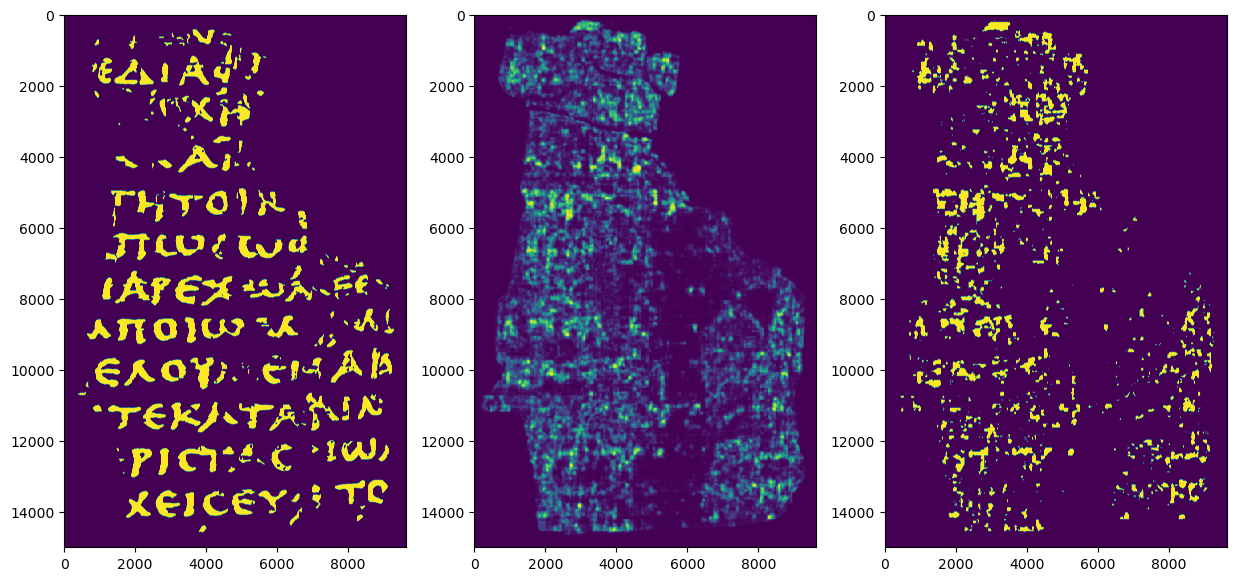

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([86951659., 15124683.,  9833906.,  7286149.,  5489006.,  4175771.,
         3264078.,  2532202.,  1983154.,  1602346.,  1337440.,  1148352.,
         1018335.,   897573.,   661969.,   456637.,   320951.,   218920.,
          161326.,    92599.]),
 array([1.12183221e-07, 4.99707818e-02, 9.99414515e-02, 1.49912121e-01,
        1.99882791e-01, 2.49853460e-01, 2.99824130e-01, 3.49794800e-01,
        3.99765469e-01, 4.49736139e-01, 4.99706809e-01, 5.49677478e-01,
        5.99648148e-01, 6.49618818e-01, 6.99589487e-01, 7.49560157e-01,
        7.99530827e-01, 8.49501496e-01, 8.99472166e-01, 9.49442836e-01,
        9.99413505e-01]),
 <BarContainer object of 20 artists>)

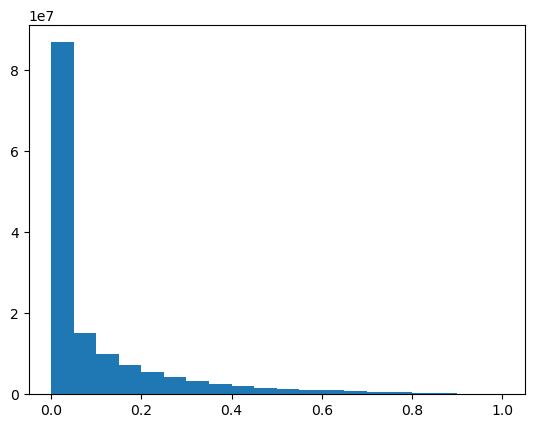

In [54]:
plt.hist(mask_pred.flatten(), bins=20)

In [55]:
# GPU VRAM 5.2GB/16.0GB A4000